In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern
from typing import Tuple, Dict, Literal, Optional
import time
from typing import Dict, Tuple
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# load data 

df = pd.read_csv('C:\\Users\\20213697\\OneDrive - TU Eindhoven\\2025-26\\AIES\\Data analysis and learning methods\\Assignment 2\\faces\\fer2013.csv')

print("Loaded FER-2013 with shape:", df.shape)
print(df["Usage"].value_counts())
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\20213697\\OneDrive - TU Eindhoven\\2025-26\\AIES\\Data analysis and learning methods\\Assignment 2\\faces\\fer2013.csv'

In [ ]:
# Define label mapping

label_map = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

In [4]:
# Convert pixels string to 48x48 numpy array

def pixels_to_array(pixels_str):
    pixels = np.fromstring(pixels_str, sep=" ", dtype=np.uint8)
    return pixels.reshape(48, 48)

In [5]:
def extract_split(df, usage):
    subset = df[df["Usage"] == usage]
    X = np.stack(subset["pixels"].apply(pixels_to_array).to_numpy())
    y = subset["emotion"].to_numpy(dtype=np.int64)
    # normalize to [0,1]
    X = X.astype(np.float32) / 255.0
    print(f"{usage}: {X.shape}, {y.shape}")
    return X, y

X_train, y_train = extract_split(df, "Training")
X_public, y_public = extract_split(df, "PublicTest")
X_private, y_private = extract_split(df, "PrivateTest")

Training: (28709, 48, 48), (28709,)
PublicTest: (3589, 48, 48), (3589,)
PrivateTest: (3589, 48, 48), (3589,)


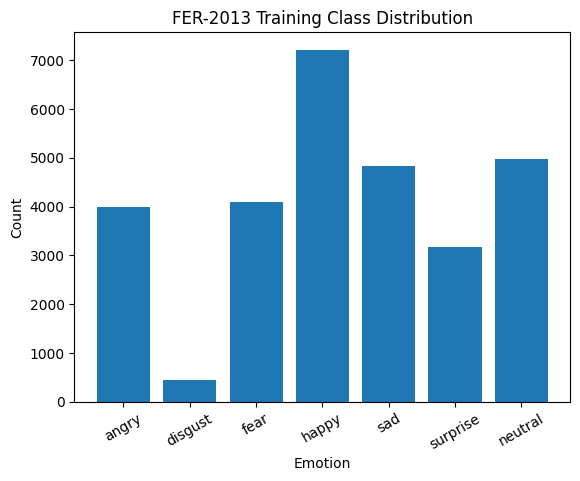

In [6]:
# Check class distribution in training set

unique, counts = np.unique(y_train, return_counts=True)
plt.bar([label_map[i] for i in unique], counts)
plt.xticks(rotation=30)
plt.title("FER-2013 Training Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [7]:
# Compute class weights to handle imbalance

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {label_map[c]: w for c, w in zip(classes, class_weights)}
print("Class weights (use for sklearn models):")
print(class_weights_dict)

Class weights (use for sklearn models):
{'angry': np.float64(1.0266046844269623), 'disgust': np.float64(9.406618610747051), 'fear': np.float64(1.0010460615781582), 'happy': np.float64(0.5684387684387684), 'sad': np.float64(0.8491274770777877), 'surprise': np.float64(1.293372978330405), 'neutral': np.float64(0.8260394187886635)}


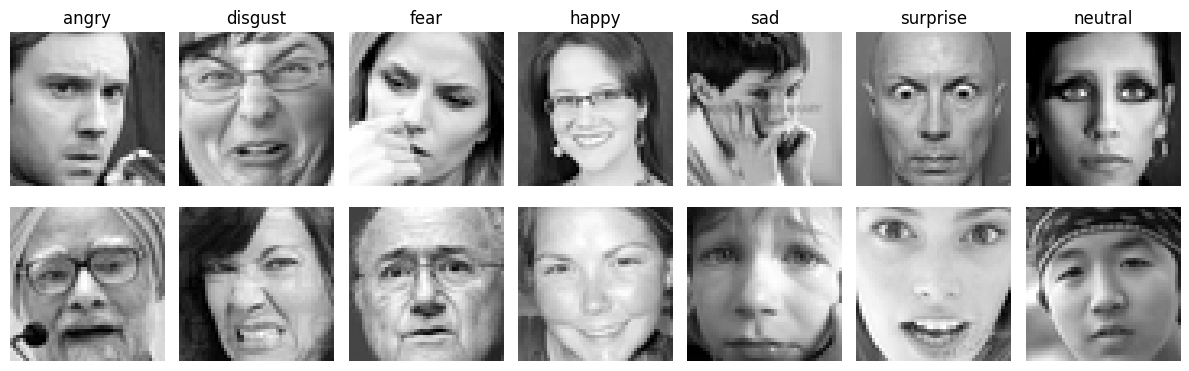

In [8]:
# Visualize some samples from each class

fig, axes = plt.subplots(2, 7, figsize=(12, 4))
for i, c in enumerate(classes):
    idxs = np.where(y_train == c)[0]
    for j in range(2):
        axes[j, i].imshow(X_train[idxs[j]], cmap="gray")
        axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title(label_map[c])
plt.tight_layout()
plt.show()

In [9]:
FEATURE_KIND: Literal["hog", "lbp", "raw"] = "hog"   # "hog" | "lbp" | "raw"
APPLY_SCALER: bool = True
APPLY_PCA: bool = True
PCA_VARIANCE: float = 0.95   # keep 95% variance (ignored if PCA_N_COMPONENTS is set)
PCA_N_COMPONENTS: Optional[int] = None  # e.g., 256; set to None to use PCA_VARIANCE

In [10]:
# A compact PCA for fuzzy model (low-dimensional)
MAKE_FUZZY_FRIENDLY_COPY: bool = True
FUZZY_PCA_N_COMPONENTS: int = 32

In [11]:
# HOG params (good balance for 48x48)
HOG_PARAMS = dict(
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    transform_sqrt=True,
    feature_vector=True)

In [12]:
# LBP params (uniform LBP histograms)
LBP_PARAMS = dict(
    P=8,        # neighbors
    R=1.0,      # radius
    method="uniform"
)


In [13]:
# Feature extractors

def extract_raw_pixels(X: np.ndarray) -> np.ndarray:
    # X: (N, 48, 48) -> (N, 2304)
    return X.reshape(len(X), -1).astype(np.float32)

In [14]:
def extract_hog_batch(X: np.ndarray, params: Dict) -> np.ndarray:
    feats = [hog(img, **params) for img in X]
    return np.asarray(feats, dtype=np.float32)

In [15]:
def extract_lbp_hist_batch(X: np.ndarray, P: int, R: float, method: str) -> np.ndarray:
    # Uniform LBP: number of bins = P + 2
    n_bins = P + 2 if method == "uniform" else int(X.max()) + 1
    feats = []
    for img in X:
        lbp = local_binary_pattern(img, P=P, R=R, method=method)
        # histogram over LBP codes
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype(np.float32)
        hist = hist / (hist.sum() + 1e-8)  # normalize to sum=1
        feats.append(hist)
    return np.asarray(feats, dtype=np.float32)

In [16]:
def make_features(X: np.ndarray, kind: str) -> np.ndarray:
    if kind == "raw":
        return extract_raw_pixels(X)
    elif kind == "hog":
        return extract_hog_batch(X, HOG_PARAMS)
    elif kind == "lbp":
        return extract_lbp_hist_batch(X, **LBP_PARAMS)
    else:
        raise ValueError(f"Unknown FEATURE_KIND: {kind}")

In [17]:
# Build features for all splits

print(f"Extracting '{FEATURE_KIND}' features...")

Xtr_feat = make_features(X_train, FEATURE_KIND)
Xpub_feat = make_features(X_public, FEATURE_KIND)
Xpri_feat = make_features(X_private, FEATURE_KIND)

print("Feature shapes:")
print("  train :", Xtr_feat.shape)
print("  public:", Xpub_feat.shape)
print("  private:", Xpri_feat.shape)


Extracting 'hog' features...
Feature shapes:
  train : (28709, 800)
  public: (3589, 800)
  private: (3589, 800)


In [18]:
# Standardization (fit ONLY on train, apply to all)

scaler = None
if APPLY_SCALER:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_feat = scaler.fit_transform(Xtr_feat)
    Xpub_feat = scaler.transform(Xpub_feat)
    Xpri_feat = scaler.transform(Xpri_feat)
    print("Applied StandardScaler.")

Applied StandardScaler.


In [19]:
# PCA (fit ONLY on train, apply to all)

pca = None
if APPLY_PCA:
    if PCA_N_COMPONENTS is not None:
        pca = PCA(n_components=PCA_N_COMPONENTS, svd_solver="auto", random_state=42)
    else:
        pca = PCA(n_components=PCA_VARIANCE, svd_solver="full", random_state=42)
    Xtr_feat = pca.fit_transform(Xtr_feat)
    Xpub_feat = pca.transform(Xpub_feat)
    Xpri_feat = pca.transform(Xpri_feat)
    if hasattr(pca, "n_components_"):
        print(f"PCA reduced to {pca.n_components_} dims; explained var ratio sum = {pca.explained_variance_ratio_.sum():.3f}")
    else:
        print("Applied PCA.")

PCA reduced to 247 dims; explained var ratio sum = 0.950


In [20]:
# Optional compact copy for fuzzy classifier

Xtr_fuzzy = Xpub_fuzzy = Xpri_fuzzy = None
pca_fuzzy = None
if MAKE_FUZZY_FRIENDLY_COPY:
    # If we already applied PCA and it is <= FUZZY_PCA_N_COMPONENTS, just reuse.
    if APPLY_PCA and Xtr_feat.shape[1] <= FUZZY_PCA_N_COMPONENTS:
        Xtr_fuzzy, Xpub_fuzzy, Xpri_fuzzy = Xtr_feat, Xpub_feat, Xpri_feat
        pca_fuzzy = pca  # same mapping
        print(f"Fuzzy copy: reused existing PCA features ({Xtr_feat.shape[1]} dims).")
    else:
        # Fit a separate PCA on the (optionally standardized) base features (without prior PCA)
        # Recompute base features quickly to avoid stacking PCA on PCA:
        Xtr_base = make_features(X_train, FEATURE_KIND)
        Xpub_base = make_features(X_public, FEATURE_KIND)
        Xpri_base = make_features(X_private, FEATURE_KIND)
        if APPLY_SCALER:
            sc_fuzzy = StandardScaler(with_mean=True, with_std=True)
            Xtr_base = sc_fuzzy.fit_transform(Xtr_base)
            Xpub_base = sc_fuzzy.transform(Xpub_base)
            Xpri_base = sc_fuzzy.transform(Xpri_base)
        pca_fuzzy = PCA(n_components=FUZZY_PCA_N_COMPONENTS, svd_solver="auto", random_state=42)
        Xtr_fuzzy = pca_fuzzy.fit_transform(Xtr_base)
        Xpub_fuzzy = pca_fuzzy.transform(Xpub_base)
        Xpri_fuzzy = pca_fuzzy.transform(Xpri_base)
        print(f"Fuzzy copy: PCA to {FUZZY_PCA_N_COMPONENTS} dims.")

Fuzzy copy: PCA to 32 dims.


In [21]:
# Summary

def _shape(a): return None if a is None else tuple(a.shape)
print("\nFinal feature matrices:")
print("  Train :", _shape(Xtr_feat))
print("  Public:", _shape(Xpub_feat))
print("  Private:", _shape(Xpri_feat))
print("  (Fuzzy):", _shape(Xtr_fuzzy))


Final feature matrices:
  Train : (28709, 247)
  Public: (3589, 247)
  Private: (3589, 247)
  (Fuzzy): (28709, 32)


In [22]:
# helpers

label_map = {
    0: "angry", 1: "disgust", 2: "fear", 3: "happy",
    4: "sad", 5: "surprise", 6: "neutral"
}
classes = np.array(sorted(np.unique(y_train)))

def class_weights_from_y(y: np.ndarray) -> Dict[int, float]:
    w = compute_class_weight("balanced", classes=classes, y=y)
    return {int(c): float(wi) for c, wi in zip(classes, w)}

CLASS_WEIGHTS = class_weights_from_y(y_train)

In [23]:
def plot_conf_mat(cm: np.ndarray, title: str):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels([label_map[c] for c in classes], rotation=30, ha="right")
    ax.set_yticklabels([label_map[c] for c in classes])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


In [24]:
def evaluate_model(name: str, model, Xtr, ytr, Xpub, ypub, Xpri, ypri):
    print(f"\n=== {name} ===")
    t0 = time.time()
    model.fit(Xtr, ytr)
    t_train = time.time() - t0

    for split_name, X, y in [("Public", Xpub, ypub), ("Private", Xpri, ypri)]:
        yp = model.predict(X)
        acc = accuracy_score(y, yp)
        print(f"{split_name} accuracy: {acc:.4f}")
        print("Classification report:")
        print(classification_report(y, yp, target_names=[label_map[c] for c in classes], zero_division=0))
        cm = confusion_matrix(y, yp, labels=classes)
        plot_conf_mat(cm, f"{name} — {split_name} Confusion Matrix")

    print(f"Train time: {t_train:.2f}s")
    return model


=== SVM (LinearSVC) ===
Public accuracy: 0.4076
Classification report:
              precision    recall  f1-score   support

       angry       0.28      0.21      0.24       467
     disgust       0.10      0.57      0.17        56
        fear       0.30      0.14      0.19       496
       happy       0.57      0.70      0.63       895
         sad       0.35      0.20      0.26       653
    surprise       0.44      0.65      0.53       415
     neutral       0.40      0.38      0.39       607

    accuracy                           0.41      3589
   macro avg       0.35      0.41      0.34      3589
weighted avg       0.40      0.41      0.39      3589



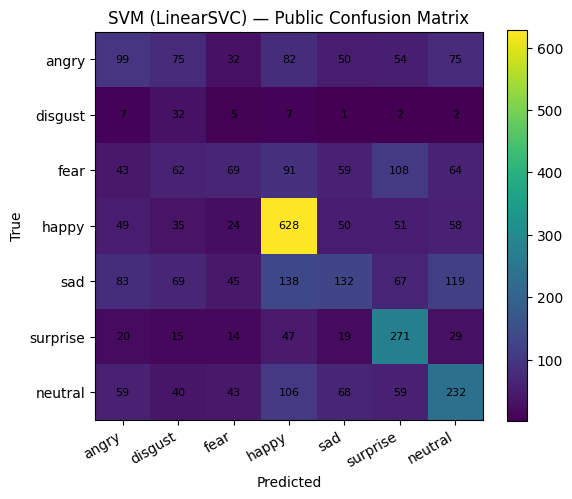

Private accuracy: 0.3973
Classification report:
              precision    recall  f1-score   support

       angry       0.24      0.17      0.20       491
     disgust       0.08      0.49      0.14        55
        fear       0.28      0.12      0.17       528
       happy       0.56      0.72      0.63       879
         sad       0.32      0.21      0.25       594
    surprise       0.41      0.62      0.50       416
     neutral       0.43      0.38      0.40       626

    accuracy                           0.40      3589
   macro avg       0.33      0.39      0.33      3589
weighted avg       0.39      0.40      0.38      3589



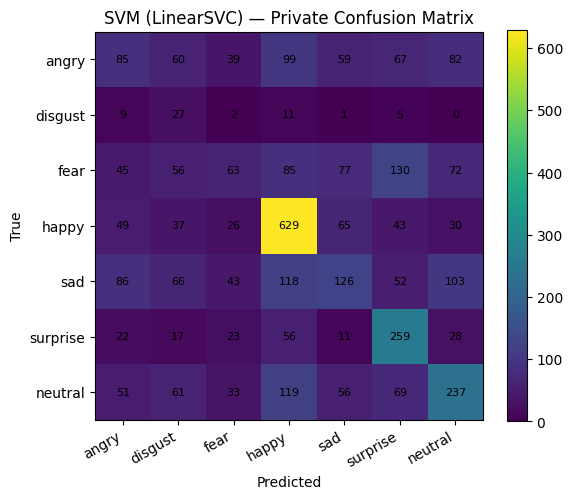

Train time: 12.64s


In [25]:
# 1) SVM
# -----------------------
# Tip: RBF SVC can be slow on ~28k x 247; start with LinearSVC (fast baseline),
# then (optionally) try RBF SVC with modest C on a reduced subset or let it run.
svm_linear = LinearSVC(
    C=1.0,
    class_weight=CLASS_WEIGHTS,  # accepts dict or 'balanced'
    max_iter=5000,
    dual=False
)

svm_rbf = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    class_weight=CLASS_WEIGHTS,
    probability=False
)

# choose which to run first
SVM_TO_RUN = "linear"  # "linear" or "rbf"
if SVM_TO_RUN == "linear":
    model_svm = evaluate_model("SVM (LinearSVC)", svm_linear, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)
else:
    model_svm = evaluate_model("SVM (RBF)", svm_rbf, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)



=== MLP ===
Public accuracy: 0.4859
Classification report:
              precision    recall  f1-score   support

       angry       0.35      0.38      0.37       467
     disgust       0.45      0.25      0.32        56
        fear       0.36      0.27      0.31       496
       happy       0.66      0.71      0.68       895
         sad       0.38      0.38      0.38       653
    surprise       0.63      0.63      0.63       415
     neutral       0.42      0.45      0.44       607

    accuracy                           0.49      3589
   macro avg       0.47      0.44      0.45      3589
weighted avg       0.48      0.49      0.48      3589



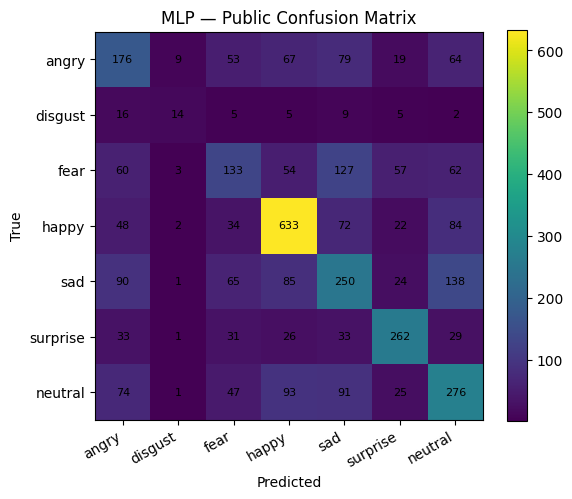

Private accuracy: 0.4678
Classification report:
              precision    recall  f1-score   support

       angry       0.34      0.32      0.33       491
     disgust       0.42      0.24      0.30        55
        fear       0.35      0.27      0.30       528
       happy       0.65      0.72      0.68       879
         sad       0.33      0.34      0.34       594
    surprise       0.61      0.56      0.58       416
     neutral       0.42      0.47      0.44       626

    accuracy                           0.47      3589
   macro avg       0.44      0.42      0.43      3589
weighted avg       0.46      0.47      0.46      3589



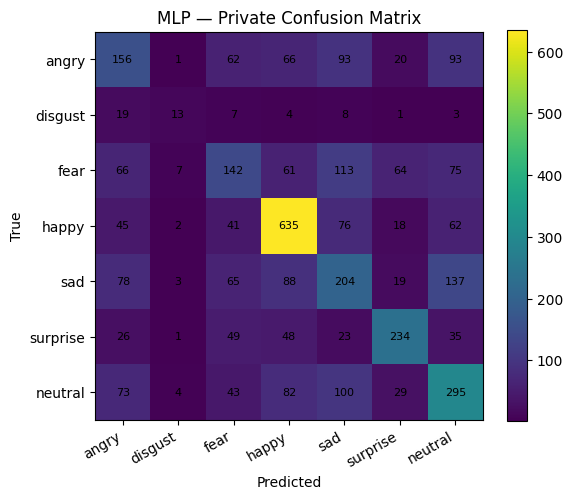

Train time: 10.12s


In [26]:
# 2) MLP
# -----------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(256,),   # good starting point
    activation="relu",
    alpha=1e-4,
    learning_rate="adaptive",
    learning_rate_init=1e-3,
    batch_size=256,
    max_iter=50,                 # keep small; early_stopping will usually stop earlier
    early_stopping=True,
    n_iter_no_change=5,
    verbose=False,
    random_state=42
)
model_mlp = evaluate_model("MLP", mlp, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)



=== Random Forest ===
Public accuracy: 0.4427
Classification report:
              precision    recall  f1-score   support

       angry       0.62      0.16      0.25       467
     disgust       1.00      0.25      0.40        56
        fear       0.64      0.18      0.28       496
       happy       0.37      0.95      0.53       895
         sad       0.46      0.21      0.29       653
    surprise       0.88      0.48      0.62       415
     neutral       0.45      0.37      0.41       607

    accuracy                           0.44      3589
   macro avg       0.63      0.37      0.40      3589
weighted avg       0.54      0.44      0.40      3589



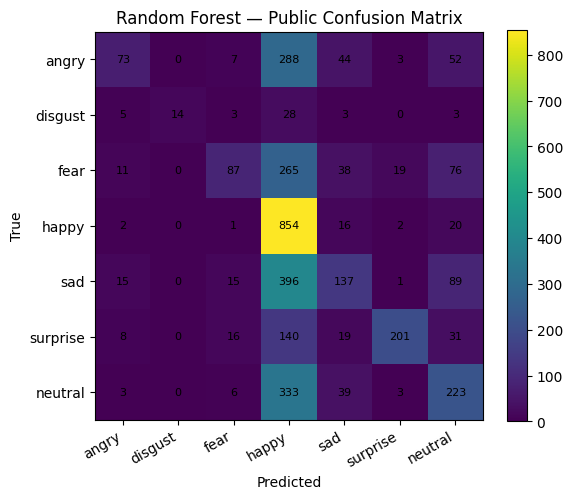

Private accuracy: 0.4324
Classification report:
              precision    recall  f1-score   support

       angry       0.63      0.15      0.24       491
     disgust       1.00      0.29      0.45        55
        fear       0.64      0.16      0.26       528
       happy       0.37      0.94      0.53       879
         sad       0.43      0.21      0.28       594
    surprise       0.87      0.47      0.61       416
     neutral       0.43      0.37      0.39       626

    accuracy                           0.43      3589
   macro avg       0.62      0.37      0.39      3589
weighted avg       0.53      0.43      0.39      3589



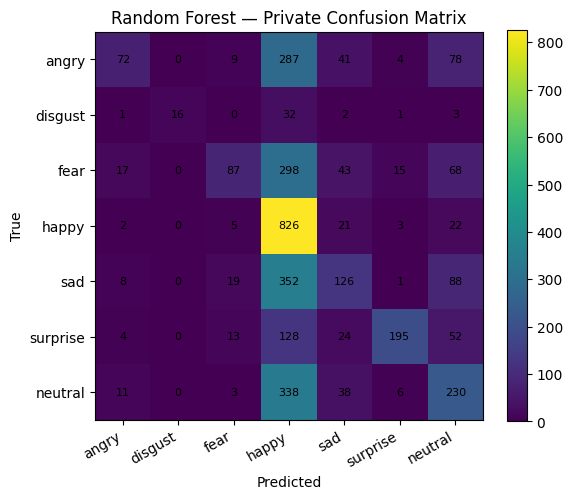

Train time: 45.48s


In [27]:
# 3) Random Forest
# -----------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)
model_rf = evaluate_model("Random Forest", rf, Xtr_feat, y_train, Xpub_feat, y_public, Xpri_feat, y_private)



=== Fuzzy Baseline (Fuzzy C-Means) ===
Public accuracy: 0.3391
Classification report:
              precision    recall  f1-score   support

       angry       0.27      0.14      0.18       467
     disgust       0.07      0.62      0.12        56
        fear       0.25      0.10      0.14       496
       happy       0.62      0.49      0.55       895
         sad       0.29      0.37      0.33       653
    surprise       0.38      0.58      0.46       415
     neutral       0.33      0.23      0.27       607

    accuracy                           0.34      3589
   macro avg       0.31      0.36      0.29      3589
weighted avg       0.38      0.34      0.34      3589



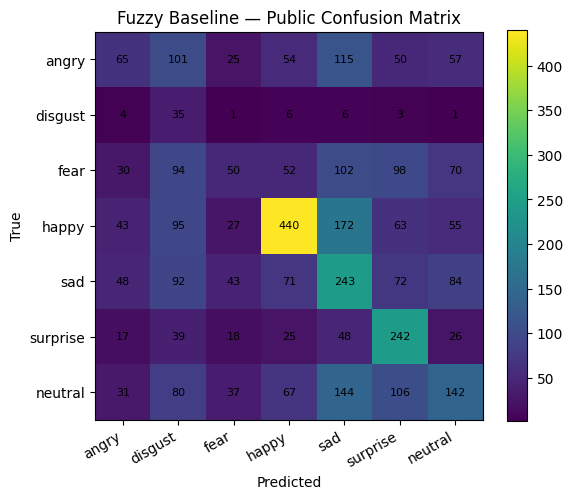

Private accuracy: 0.3388
Classification report:
              precision    recall  f1-score   support

       angry       0.29      0.13      0.18       491
     disgust       0.06      0.58      0.10        55
        fear       0.25      0.11      0.15       528
       happy       0.65      0.52      0.58       879
         sad       0.27      0.37      0.31       594
    surprise       0.36      0.56      0.44       416
     neutral       0.36      0.26      0.30       626

    accuracy                           0.34      3589
   macro avg       0.32      0.36      0.29      3589
weighted avg       0.39      0.34      0.34      3589



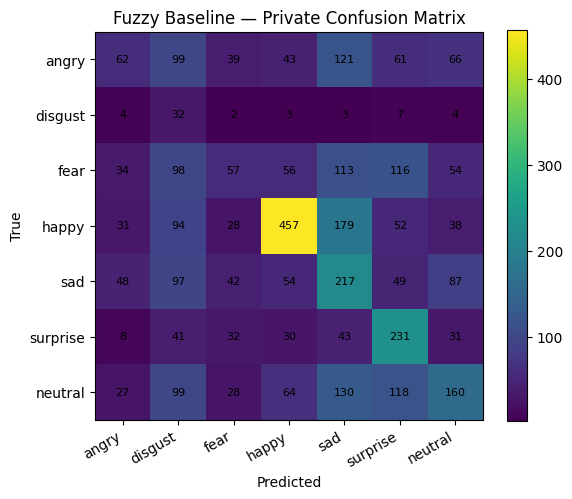

In [28]:
# 4) Simple Fuzzy Baseline (Fuzzy c-means + nearest-rule) — low-dim features
# -----------------------
# Your assignment mentions PyFUME; if you install and want to use it, swap this baseline
# with a PyFUME-based classifier trained on Xtr_fuzzy (<= ~32 dims). Below is a practical
# baseline using fuzzy c-means clustering (skfuzzy) per class, then classify by the
# nearest cluster center using membership-weighted distance.

try:
    import skfuzzy as fuzz

    assert Xtr_fuzzy is not None and Xtr_fuzzy.size > 0, "Xtr_fuzzy is missing; enable MAKE_FUZZY_FRIENDLY_COPY in Step 3."

    # hyperparameters
    CLUSTERS_PER_CLASS = 2
    MAXITER = 100
    M = 2.0  # fuzziness

    # learn class-wise cluster centers in fuzzy space
    centers = []
    labels_for_centers = []
    for c in classes:
        Xc = Xtr_fuzzy[y_train == c]
        # transpose to shape (features, samples) for skfuzzy.cmeans
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            Xc.T, c=CLUSTERS_PER_CLASS, m=M, error=1e-5, maxiter=MAXITER, init=None, seed=42
        )
        centers.append(cntr)  # (clusters_per_class, n_features)
        labels_for_centers += [c] * CLUSTERS_PER_CLASS
    centers = np.vstack(centers)
    labels_for_centers = np.array(labels_for_centers)

    def fuzzy_predict(Xf: np.ndarray) -> np.ndarray:
        # compute distances to all centers; assign to nearest center
        # (skfuzzy has cmeans_predict, but we can do euclidean here)
        # Xf: (N, d), centers: (K, d)
        diffs = Xf[:, None, :] - centers[None, :, :]
        dists2 = np.sum(diffs * diffs, axis=2)  # (N, K)
        nearest = np.argmin(dists2, axis=1)     # (N,)
        return labels_for_centers[nearest]

    # Evaluate fuzzy baseline
    print("\n=== Fuzzy Baseline (Fuzzy C-Means) ===")
    for split_name, Xf, y in [("Public", Xpub_fuzzy, y_public), ("Private", Xpri_fuzzy, y_private)]:
        yp = fuzzy_predict(Xf)
        acc = accuracy_score(y, yp)
        print(f"{split_name} accuracy: {acc:.4f}")
        print("Classification report:")
        print(classification_report(y, yp, target_names=[label_map[c] for c in classes], zero_division=0))
        cm = confusion_matrix(y, yp, labels=classes)
        plot_conf_mat(cm, f"Fuzzy Baseline — {split_name} Confusion Matrix")

except Exception as e:
    print("\n[Fuzzy baseline skipped]")
    print("Reason:", repr(e))
    print("Tip: Install scikit-fuzzy (skfuzzy) OR use PyFUME on Xtr_fuzzy/Xpub_fuzzy/Xpri_fuzzy "
          "for a proper fuzzy classifier per the assignment. Keep features low-dimensional (~32).")
